# GraphTransformer Demo

## Overview
- Demonstrates `GraphTransformer` inside BioNeuralNet’s unified GNN API.
- Loads TCGA-BRCA when available; otherwise builds a synthetic regression task.
- Constructs a Gaussian kNN feature graph from standardized omics.
- Learns node embeddings and forms subject latents via `Z = X · E`.
- Evaluates a Ridge baseline and visualizes embeddings (t-SNE/PCA), calibration (pred–vs–true hexbin), residuals, and the training curve.
- Saves figures and artifacts to `visualization_results`.

## What This Notebook Does
- Prepares data: standardizes omics, sets seeds for reproducibility.
- Builds a Gaussian kNN feature graph (`gen_gaussian_knn_graph`).
- Trains `GraphTransformer` via `GNNEmbedding(model_type="GraphTransformer")` and extracts node embeddings `E`.
- Computes subject projections `Z_train`, `Z_test` with `Z = X · E`.
- Fits a Ridge pipeline; reports RMSE, MSE, and R²; exports metrics to JSON.
- Visualizes: embedding scatter (t-SNE/PCA), pred–vs–true hexbin with identity/calibration, residual histogram, and training loss curve.
- Saves artifacts: `E` (`.csv`, `.npy`), `Z_test` (`.npy`), predictions (`.csv`), metrics (`.json`), and figures (`.png`).

## GraphTransformer’s Role in BioNeuralNet
- Implements transformer-based attention on the feature graph to capture long-range dependencies (see `bioneuralnet/network_embedding/graph_transformer.py`).
- Plugs into `GNNEmbedding` so it’s swappable with `GCN`, `GAT`, `SAGE`, `GIN` by setting `model_type='GraphTransformer'`.
- Produces robust node embeddings consumed across BioNeuralNet pipelines for downstream tasks.
- Enhances representation quality via residual connections, normalization, and dropout for stability.
- Used by CLI evaluators (e.g., `examples/graph_transformer_evaluation.py`) to run end-to-end experiments.

## Why A Feature Graph
- Each node is an omics feature; edges capture similarity (Gaussian kNN) across subjects.
- Encodes co-variation and potential biological relationships that tabular models ignore.
- Graph-based embeddings let downstream models operate in a denoised, structured latent space.

In [17]:
import os, sys
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

cands = [Path.cwd()] + list(Path.cwd().parents)
for p in cands:
    if (p / "bioneuralnet").exists():
        sys.path.insert(0, str(p))
        break

from bioneuralnet.network_embedding.gnn_embedding import GNNEmbedding
from bioneuralnet.datasets import DatasetLoader
from bioneuralnet.utils.graph import gen_gaussian_knn_graph

np.random.seed(42)
torch.manual_seed(42)
VIZ_DIR = Path.cwd() / "visualization_results"
os.makedirs(VIZ_DIR, exist_ok=True)


## Data & Graph Construction
- BRCA loader yields `omics_data` (N×D) and `phenotype_data` labels.
- Synthetic fallback creates a linear target when dataset is unavailable.
- Columns are standardized before graph building for stable distance scales.
- `gen_gaussian_knn_graph` returns a D×D feature graph used by the GNN.

In [18]:
use_dataset = True
try:
    ds = DatasetLoader("brca")
    omics_data = ds.data["rna"]
    phenotype_data = ds.data["pam50"]
except Exception:
    use_dataset = False

if not use_dataset:
    n_samples = 120
    n_features = 60
    omics_data = pd.DataFrame(np.random.normal(0, 1, size=(n_samples, n_features)),
                              columns=[f"f_{i}" for i in range(n_features)])
    w = np.random.normal(0, 1, size=n_features)
    phenotype_data = pd.DataFrame({
        "target": omics_data.values.dot(w) + np.random.normal(0, 0.5, size=n_samples)
    }, index=omics_data.index)

omics_data = omics_data.apply(pd.to_numeric, errors="coerce")
omics_data = omics_data.fillna(omics_data.mean())
scaler_all = StandardScaler()
omics_data = pd.DataFrame(scaler_all.fit_transform(omics_data), columns=omics_data.columns, index=omics_data.index)


## Train, Embed & Evaluate
- Initializes `GNNEmbedding` with `model_type="GraphTransformer"`.
- Fits the model and obtains feature embeddings `E`.
- Projects subject features to latent space `Z_train`, `Z_test` via `X·E`.
- Trains a Ridge regression pipeline and reports MSE, RMSE, and R².

In [19]:
if isinstance(phenotype_data, pd.DataFrame):
    y = pd.to_numeric(phenotype_data.iloc[:, 0], errors="coerce").fillna(method="ffill").fillna(method="bfill")
else:
    y = pd.to_numeric(phenotype_data.squeeze(), errors="coerce").fillna(method="ffill").fillna(method="bfill")
adjacency_matrix = gen_gaussian_knn_graph(omics_data, k=15)
X_train, X_test, y_train, y_test = train_test_split(omics_data, y.to_frame(name="target"), test_size=0.2, random_state=42)


C:\Users\Aarthy\AppData\Local\Temp\ipykernel_9872\2712201618.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  y = pd.to_numeric(phenotype_data.iloc[:, 0], errors="coerce").fillna(method="ffill").fillna(method="bfill")


## Visualization
- Uses t-SNE to visualize `Z_test` embeddings colored by target.
- Falls back to PCA when the data is small or degenerate.
- Saves figure to `visualization_results/gt_notebook_embeddings.png`.

In [20]:
gnn = GNNEmbedding(adjacency_matrix=adjacency_matrix, omics_data=X_train, phenotype_data=y_train, model_type="GraphTransformer", hidden_dim=64, layer_num=2, num_epochs=50, lr=5e-4, dropout=0.1, activation="gelu", weight_decay=0.0)
gnn.fit()
E = gnn.embed(as_df=False)
nodes = adjacency_matrix.index.tolist()
E_np = np.nan_to_num(E.detach().cpu().numpy().astype(np.float64), nan=0.0, posinf=1e6, neginf=-1e6)
X_train_nodes = np.nan_to_num(X_train[nodes].values.astype(np.float64), nan=0.0, posinf=1e6, neginf=-1e6)
X_test_nodes = np.nan_to_num(X_test[nodes].values.astype(np.float64), nan=0.0, posinf=1e6, neginf=-1e6)
Z_train = np.nan_to_num(X_train_nodes.dot(E_np), nan=0.0, posinf=1e6, neginf=-1e6)
Z_test = np.nan_to_num(X_test_nodes.dot(E_np), nan=0.0, posinf=1e6, neginf=-1e6)
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))])
pipe.fit(Z_train, y_train.values.flatten())
y_pred = np.nan_to_num(pipe.predict(Z_test), nan=0.0, posinf=1e6, neginf=-1e6)
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test.values.flatten(), y_pred)
r2 = r2_score(y_test.values.flatten(), y_pred)
print(float(np.sqrt(mse)), float(mse), float(r2))


2025-11-12 14:35:25,935 - bioneuralnet.network_embedding.gnn_embedding - INFO - Initialized GNNEmbedding. device=cpu
2025-11-12 14:35:25,935 - bioneuralnet.network_embedding.gnn_embedding - INFO - No output_dir provided; using temporary directory: C:\Users\Aarthy\AppData\Local\Temp\tmpipttb9al
2025-11-12 14:35:25,943 - bioneuralnet.network_embedding.gnn_embedding - INFO - Starting training process.
2025-11-12 14:35:25,945 - bioneuralnet.network_embedding.gnn_embedding - INFO - Preparing node features.
2025-11-12 14:35:25,945 - bioneuralnet.network_embedding.gnn_embedding - INFO - Found 1687 common features between network and omics data.
2025-11-12 14:35:32,990 - bioneuralnet.network_embedding.gnn_embedding - WARNING - Eigenvector centrality failed for component size 1687; defaulting to 0.
2025-11-12 14:35:32,990 - bioneuralnet.network_embedding.gnn_embedding - WARNING - No clinical data found. Using centrality measures and statistical features.
2025-11-12 14:35:34,315 - bioneuralnet.n

0.5969138743633251 0.3563061734074355 0.6953031692016465


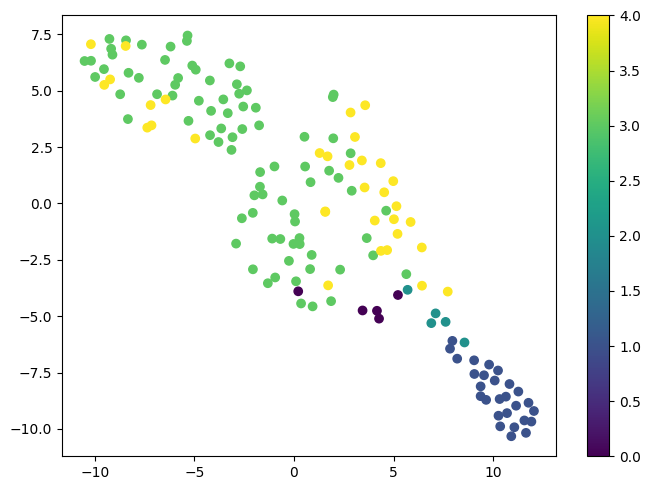

In [21]:
plt.figure(figsize=(7,5))
col_std = Z_test.std(axis=0)
row_std = Z_test.std(axis=1)
degenerate = (float(np.var(Z_test)) < 1e-12) or np.all(col_std < 1e-12) or np.all(row_std < 1e-12)
if degenerate or Z_test.shape[0] < 15:
    n_components_pca = max(1, min(2, Z_test.shape[1], Z_test.shape[0]))
    pca = PCA(n_components=n_components_pca, random_state=42)
    P = pca.fit_transform(Z_test)
    x = P[:,0]
    y2 = P[:,1] if P.shape[1] > 1 else np.zeros_like(x)
    s = plt.scatter(x, y2, c=y_test.values.flatten(), cmap="viridis")
else:
    perplexity = max(5, min(30, (Z_test.shape[0]-1)//3))
    tsne = TSNE(n_components=2, random_state=42, init="random", learning_rate="auto", perplexity=perplexity)
    T = tsne.fit_transform(Z_test)
    s = plt.scatter(T[:,0], T[:,1], c=y_test.values.flatten(), cmap="viridis")
plt.colorbar(s)
plt.tight_layout()
plt.savefig(VIZ_DIR / "gt_notebook_embeddings.png", dpi=300)
plt.show()


## Inference & Metrics
- Predicted vs True scatter and residual histogram.
- Saves JSON metrics and NPY/CSV artifacts.


In [23]:
try:
    _ = Z_test
except NameError:
    if 'E_np' not in globals():
        E_np = np.nan_to_num(E.detach().cpu().numpy().astype(np.float64), nan=0.0, posinf=1e6, neginf=-1e6)
    X_test_nodes = np.nan_to_num(X_test[nodes].values.astype(np.float64), nan=0.0, posinf=1e6, neginf=-1e6)
    Z_test = np.nan_to_num(X_test_nodes.dot(E_np), nan=0.0, posinf=1e6, neginf=-1e6)
Z_test = np.atleast_2d(Z_test)
assert Z_test.shape[0] > 0 and Z_test.shape[1] > 0


In [24]:
def predict_from_df(X_df):
    Xn = np.nan_to_num(X_df[nodes].values.astype(np.float64), nan=0.0, posinf=1e6, neginf=-1e6)
    Zn = np.nan_to_num(Xn.dot(E_np), nan=0.0, posinf=1e6, neginf=-1e6)
    return pipe.predict(Zn)


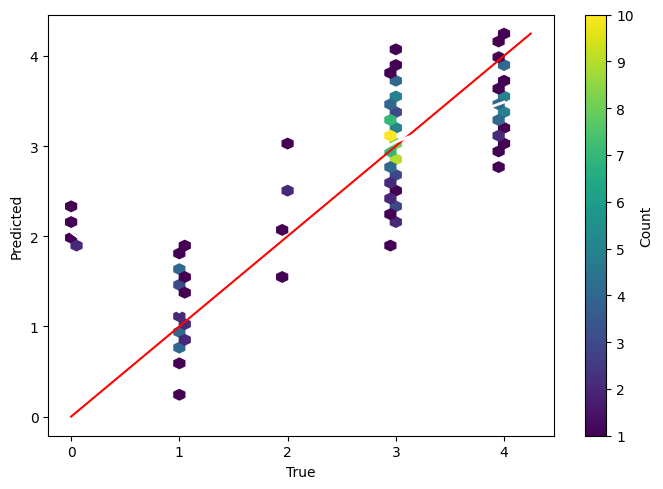

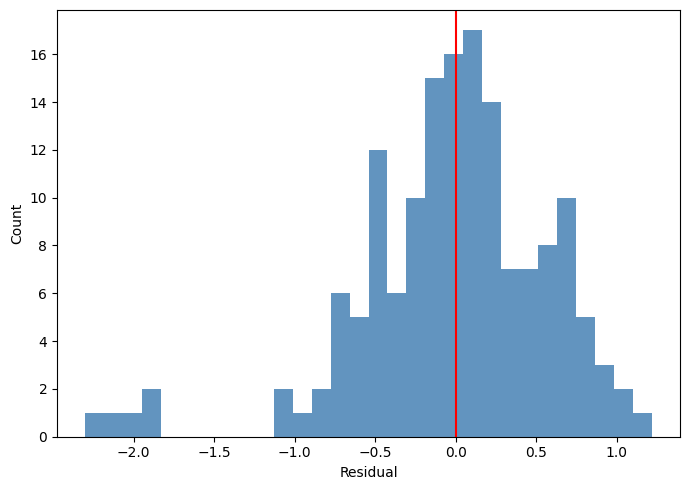

In [25]:
import json
rmse = float(np.sqrt(mse))
metrics = {'rmse': rmse, 'mse': float(mse), 'r2': float(r2)}
with open(VIZ_DIR / 'gt_metrics.json', 'w') as f:
    json.dump(metrics, f)
t = y_test.values.flatten()
p = y_pred
min_v = float(np.min([t.min(), p.min()]))
max_v = float(np.max([t.max(), p.max()]))
fig, ax = plt.subplots(figsize=(7,5))
hb = ax.hexbin(t, p, gridsize=40, cmap='viridis', mincnt=1)
ax.plot([min_v, max_v], [min_v, max_v], color='red', lw=1.5)
bins = np.linspace(min_v, max_v, 20)
idx = np.digitize(t, bins)
bin_true = np.array([t[idx==i].mean() if np.any(idx==i) else np.nan for i in range(1, len(bins))])
bin_pred = np.array([p[idx==i].mean() if np.any(idx==i) else np.nan for i in range(1, len(bins))])
mask = ~np.isnan(bin_true) & ~np.isnan(bin_pred)
ax.plot(bin_true[mask], bin_pred[mask], color='white', lw=2)
ax.set_xlabel('True')
ax.set_ylabel('Predicted')
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label('Count')
fig.tight_layout()
fig.savefig(VIZ_DIR / 'gt_pred_vs_true_hexbin.png', dpi=300)
plt.show()
residuals = t - p
plt.figure(figsize=(7,5))
plt.hist(residuals, bins=30, alpha=0.85, color='steelblue')
plt.axvline(0.0, color='red', lw=1.5)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'gt_residual_hist.png', dpi=300)
plt.show()


In [26]:
E_df = pd.DataFrame(E_np, index=nodes)
E_df.to_csv(VIZ_DIR / 'gt_node_embeddings.csv', index=True)
np.save(VIZ_DIR / 'gt_node_embeddings.npy', E_np)
np.save(VIZ_DIR / 'gt_z_test.npy', Z_test)
pred_df = pd.DataFrame({'true': y_test.values.flatten(), 'pred': y_pred})
pred_df.to_csv(VIZ_DIR / 'gt_predictions.csv', index=False)


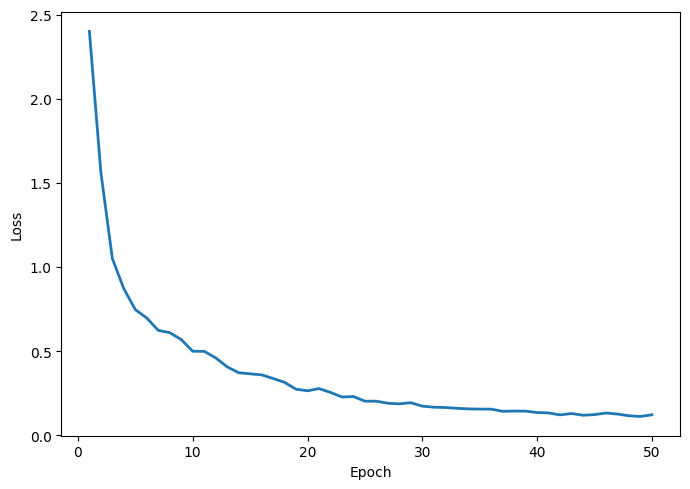

In [27]:
plt.figure(figsize=(7,5))
plt.plot(gnn.train_epochs, gnn.train_losses, lw=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.savefig(VIZ_DIR / 'gt_training_curve.png', dpi=300)
plt.show()


## Limitations & Next Steps
- Add Laplacian positional encodings for structural bias.
- Evaluate classification tasks and multi-head configs.
- Inspect attention weights and node importance.
